Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Loading annotations from: /content/drive/MyDrive/foodguard/data/expdate/Products-Real/train/annotations.json
[INFO] Training samples: 1057 | Validation samples: 187
[DEBUG] Visualizing one batch...


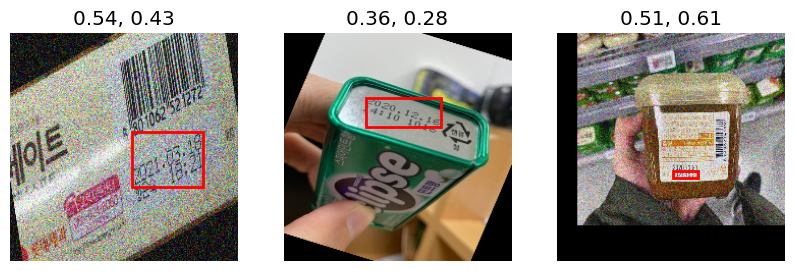

[INFO] Building MobileNetV2 Model...


/tmp/ipython-input-1708983188.py:198: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] Phase 1: Training Head...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - iou_metric: 0.0141 - loss: 0.0418 - val_iou_metric: 0.0117 - val_loss: 0.0238
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - iou_metric: 0.0203 - loss: 0.0246 - val_iou_metric: 0.0181 - val_loss: 0.0233
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - iou_metric: 0.0219 - loss: 0.0244 - val_iou_metric: 0.0135 - val_loss: 0.0238
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - iou_metric: 0.0252 - loss: 0.0241 - val_iou_metric: 0.0197 - val_loss: 0.0208
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - iou_metric: 0.0303 - loss: 0.0210 - val_iou_metric: 0.0253 - val_loss: 0.0208
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - iou_metric: 0.0218 - loss: 0.0217 - val_iou_metric: 0.0206 - val_loss: 0.0206
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - iou_metric: 0.0262 - loss: 0.0200 - val_iou_metric: 0.0207 - val_loss: 0.0192
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - iou_metric: 0.0335 - loss: 0.0206 - v

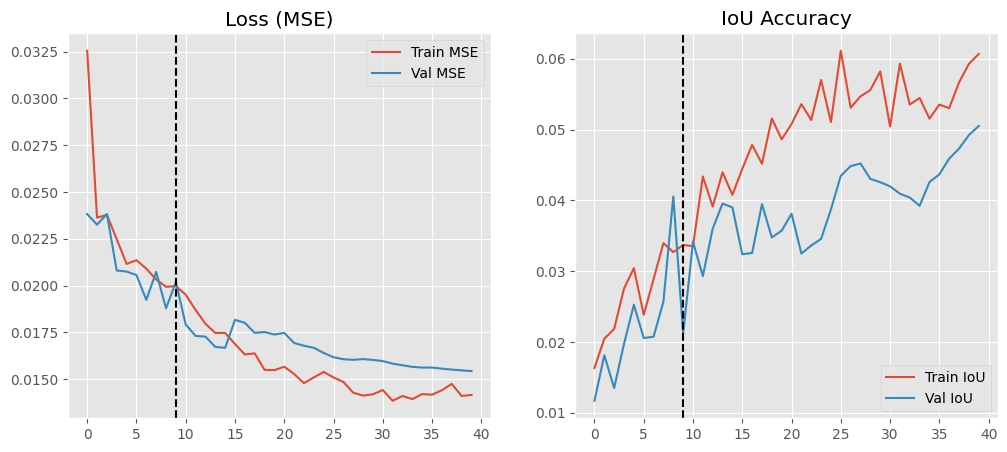

[INFO] Running Inference Test...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


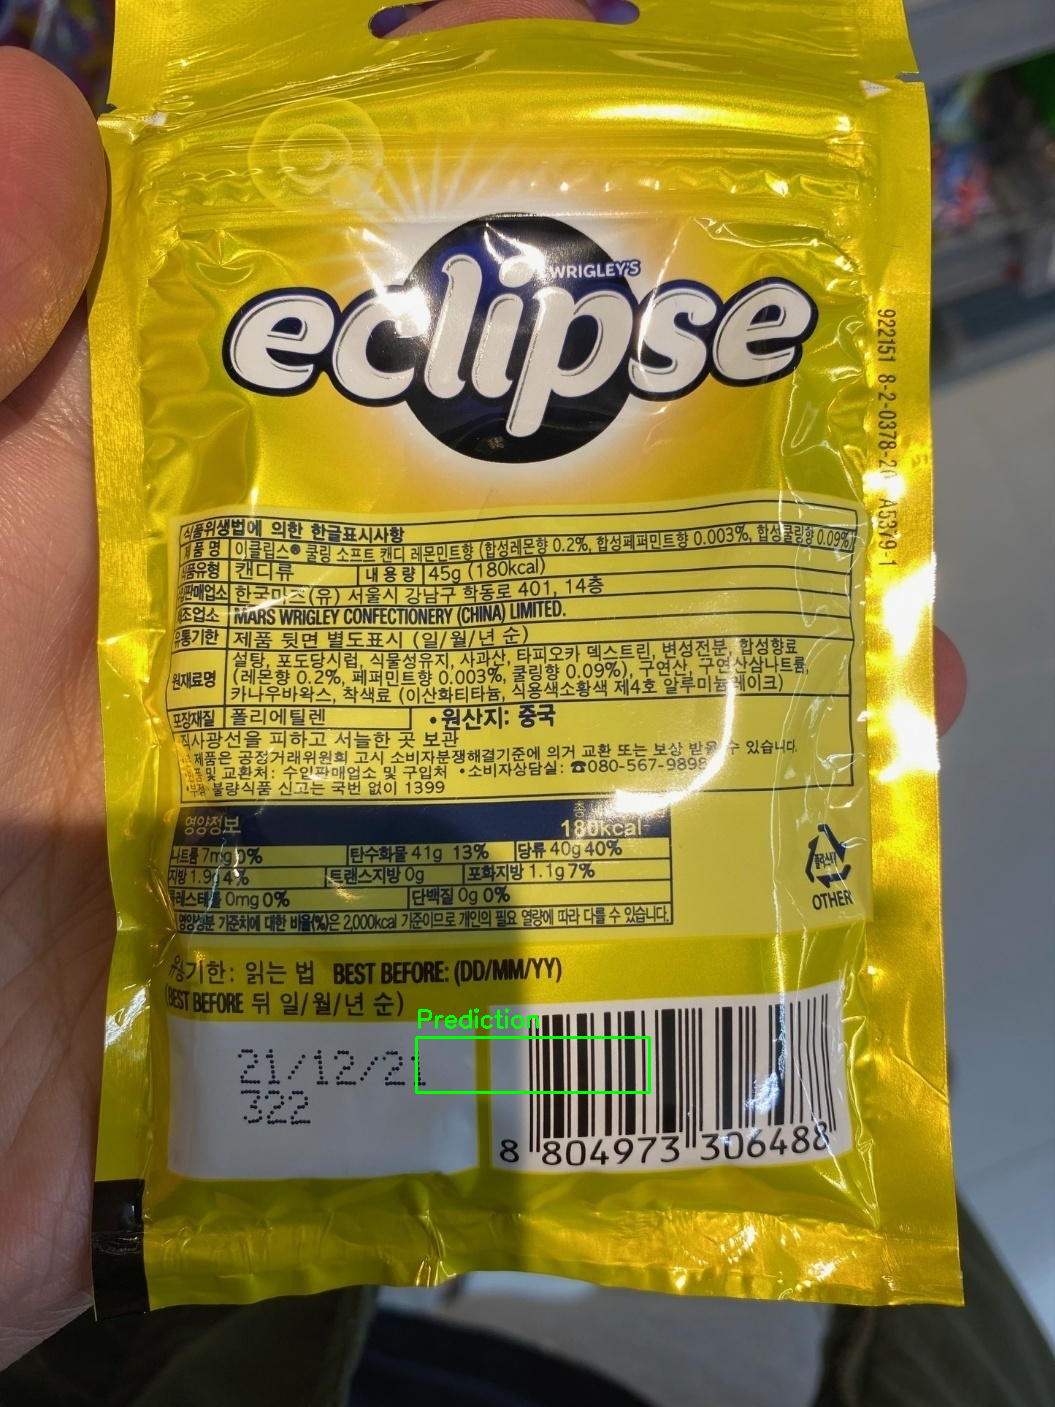

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


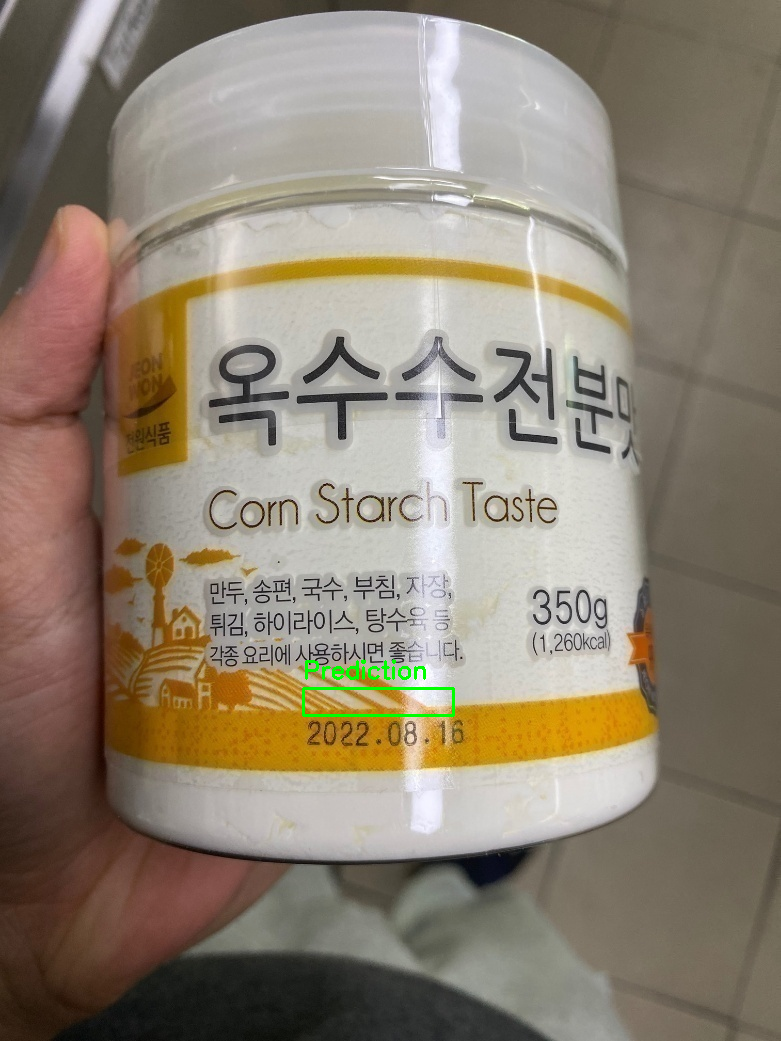

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


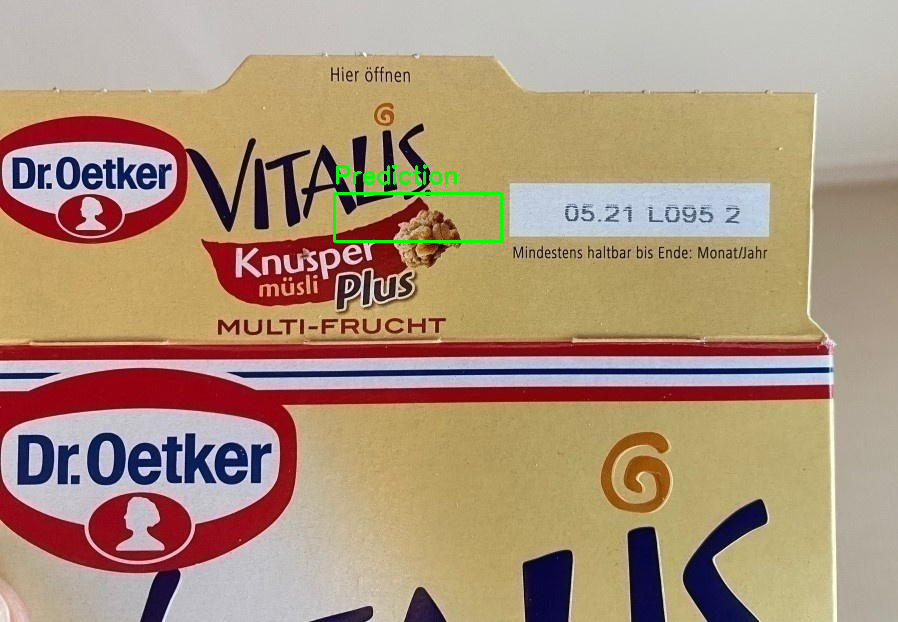

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


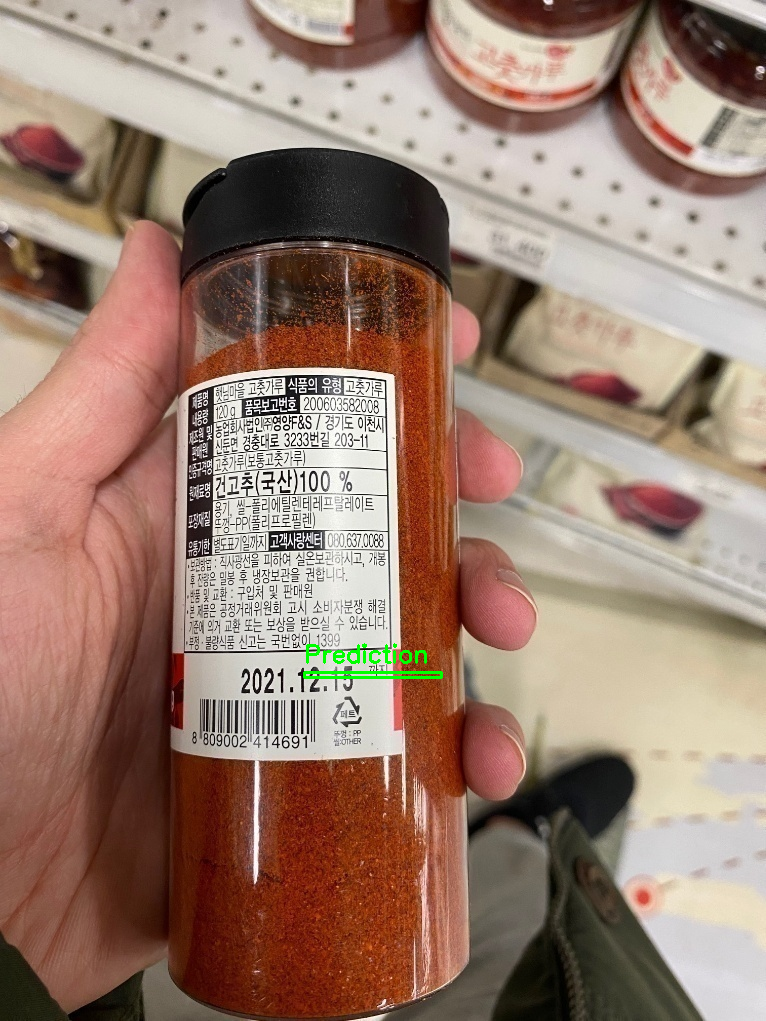

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


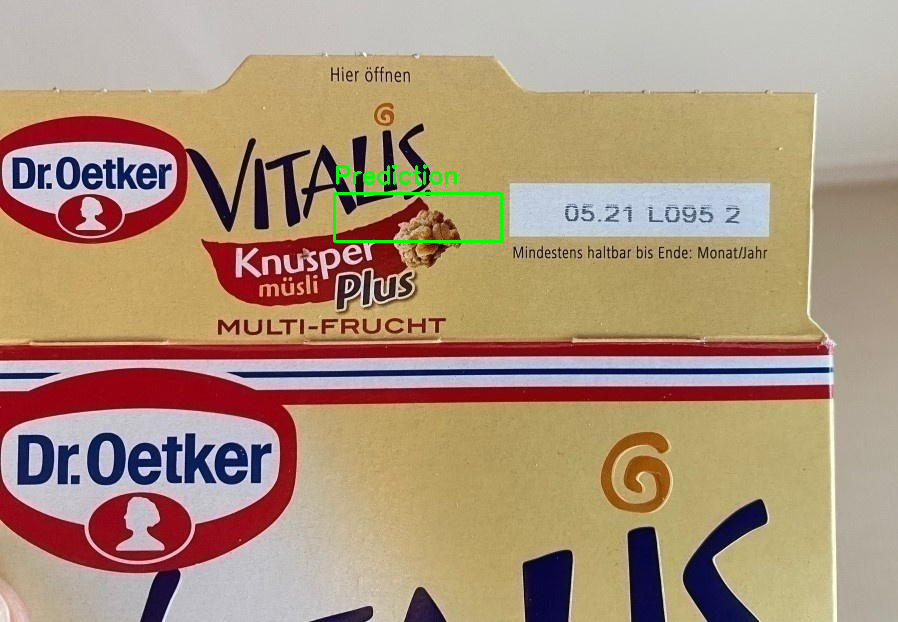

In [ ]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import albumentations as A

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount Drive
drive.mount('/content/drive')


BASE_PATH = "/content/drive/MyDrive/foodguard/data/expdate/Products-Real/train"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations.json"])
OUTPUT_PATH = "/content/drive/MyDrive/foodguard/models"

# Hyperparameters - Optimized for Stability
BATCH_SIZE = 32      # Larger batch size stabilizes gradients
IMAGE_SIZE = 224     # Standard for MobileNet, faster and reliable
LEARNING_RATE = 1e-3 # Standard Adam starting point

# Create output directory if missing
os.makedirs(OUTPUT_PATH, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(OUTPUT_PATH, "mobilenet_bbox_mse.keras")

class FoodGuardGenerator(Sequence):
    def __init__(self, metadata, image_dir, batch_size, image_size, augment=False):
        self.metadata = metadata
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment

        # Albumentations Pipeline
        self.aug = A.Compose([
            A.Rotate(limit=20, p=0.7),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.3),
            A.Affine(scale=(0.8, 1.2), translate_percent=(-0.1, 0.1), p=0.6)
        ], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']))

    def __len__(self):
        return int(np.ceil(len(self.metadata) / self.batch_size))

    def __getitem__(self, index):
        batch_meta = self.metadata[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        batch_targets = []

        for item in batch_meta:
            # Load Image
            img_path = os.path.join(self.image_dir, item['filename'])
            image = cv2.imread(img_path)

            if image is None: continue

            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Get Box (Normalized)
            box = item['bbox'] # [x1, y1, x2, y2]

            # Augmentation
            if self.augment:
                try:
                    augmented = self.aug(image=image, bboxes=[box], class_labels=['date'])
                    image = augmented['image']
                    if len(augmented['bboxes']) > 0:
                        box = augmented['bboxes'][0]
                except:
                    pass # Skip augmentation on failure

            # Preprocessing
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = preprocess_input(image) # MobileNet preprocessing (-1 to 1)

            batch_images.append(image)
            batch_targets.append(box)

        return np.array(batch_images, dtype="float32"), np.array(batch_targets, dtype="float32")

    def on_epoch_end(self):
        np.random.shuffle(self.metadata)


print(f"[INFO] Loading annotations from: {ANNOTS_PATH}")
with open(ANNOTS_PATH, 'r') as f:
    raw_data = json.load(f)

dataset = []
for filename, val in raw_data.items():
    if not os.path.exists(os.path.join(IMAGES_PATH, filename)):
        continue


    temp_img = cv2.imread(os.path.join(IMAGES_PATH, filename))
    if temp_img is None: continue
    h, w = temp_img.shape[:2]

    for ann in val['ann']:
        if ann['cls'] == 'date':
            sx, sy, ex, ey = ann['bbox']
            # Normalize to 0-1
            norm_box = [sx/w, sy/h, ex/w, ey/h]
            dataset.append({'filename': filename, 'bbox': norm_box})

# Split
train_meta, val_meta = train_test_split(dataset, test_size=0.15, random_state=42)
print(f"[INFO] Training samples: {len(train_meta)} | Validation samples: {len(val_meta)}")

# Generators
train_gen = FoodGuardGenerator(train_meta, IMAGES_PATH, BATCH_SIZE, IMAGE_SIZE, augment=True)
val_gen = FoodGuardGenerator(val_meta, IMAGES_PATH, BATCH_SIZE, IMAGE_SIZE, augment=False)

# This block proves your data is correct before wasting time training
def debug_check(generator):
    print("[DEBUG] Visualizing one batch...")
    imgs, boxes = generator.__getitem__(0)
    plt.figure(figsize=(10, 5))
    for i in range(min(3, len(imgs))):
        # Undo preprocessing for display (-1..1 -> 0..255)
        disp_img = ((imgs[i] + 1) * 127.5).astype(np.uint8)
        box = boxes[i]

        plt.subplot(1, 3, i+1)
        plt.imshow(disp_img)
        h, w = disp_img.shape[:2]

        # Draw Box
        rect = patches.Rectangle(
            (box[0]*w, box[1]*h),
            (box[2]-box[0])*w,
            (box[3]-box[1])*h,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        plt.gca().add_patch(rect)
        plt.title(f"{box[0]:.2f}, {box[1]:.2f}")
        plt.axis('off')
    plt.show()

debug_check(train_gen)


def iou_metric(y_true, y_pred):
    # IoU Metric for monitoring (not used for loss)
    y_true = tf.cast(tf.reshape(y_true, [-1, 4]), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, [-1, 4]), tf.float32)

    x1_t, y1_t, x2_t, y2_t = tf.split(y_true, 4, axis=1)
    x1_p, y1_p, x2_p, y2_p = tf.split(y_pred, 4, axis=1)

    intersect_x1 = tf.maximum(x1_t, x1_p)
    intersect_y1 = tf.maximum(y1_t, y1_p)
    intersect_x2 = tf.minimum(x2_t, x2_p)
    intersect_y2 = tf.minimum(y2_t, y2_p)

    intersect_area = tf.maximum(0.0, intersect_x2 - intersect_x1) * tf.maximum(0.0, intersect_y2 - intersect_y1)

    box1_area = (x2_t - x1_t) * (y2_t - y1_t)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)

    return intersect_area / (box1_area + box2_area - intersect_area + 1e-7)

print("[INFO] Building MobileNetV2 Model...")
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

base_model.trainable = False # Freeze base initially

head = base_model.output
head = GlobalAveragePooling2D()(head)
head = Flatten()(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(64, activation="relu")(head)
head = Dense(4, activation="sigmoid", name="bbox_head")(head) # Sigmoid for 0-1 coordinates

model = Model(inputs=base_model.input, outputs=head)

# COMPILE WITH MSE (Mean Squared Error)
# MSE is robust for regression and prevents "zero IoU" gradient death
model.compile(loss="mse", optimizer=Adam(learning_rate=1e-3), metrics=[iou_metric])


# Phase 1: Train Head
print("[INFO] Phase 1: Training Head...")
H1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10, # Short warm up
    verbose=1
)

# Phase 2: Fine Tune
print("[INFO] Phase 2: Fine-Tuning MobileNet...")
base_model.trainable = True
# Freeze early layers, train top layers
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(loss="mse", optimizer=Adam(learning_rate=1e-4), metrics=[iou_metric])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

H2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

model.save(MODEL_SAVE_PATH)
print(f"[INFO] Model saved to {MODEL_SAVE_PATH}")

# Merge Histories
loss = H1.history['loss'] + H2.history['loss']
val_loss = H1.history['val_loss'] + H2.history['val_loss']
iou = H1.history['iou_metric'] + H2.history['iou_metric']
val_iou = H1.history['val_iou_metric'] + H2.history['val_iou_metric']

plt.style.use("ggplot")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train MSE')
plt.plot(val_loss, label='Val MSE')
plt.title("Loss (MSE)")
plt.legend()
plt.axvline(x=9, color='k', linestyle='--') # Line marking fine-tuning start

plt.subplot(1, 2, 2)
plt.plot(iou, label='Train IoU')
plt.plot(val_iou, label='Val IoU')
plt.title("IoU Accuracy")
plt.legend()
plt.axvline(x=9, color='k', linestyle='--')

plt.show()
print("[INFO] Running Inference Test...")
indices = np.random.choice(len(val_meta), 5)
for i in indices:
    meta = val_meta[i]
    # Load and Preprocess
    img = cv2.imread(os.path.join(IMAGES_PATH, meta['filename']))
    orig = img.copy()
    h, w = img.shape[:2]

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    # Predict
    pred = model.predict(img)[0]

    # Scale back
    x1, y1, x2, y2 = int(pred[0]*w), int(pred[1]*h), int(pred[2]*w), int(pred[3]*h)

    # Draw
    cv2.rectangle(orig, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(orig, "Prediction", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2_imshow(orig)

[INFO] Plotting NEW training history...
[INFO] Plot updated successfully.


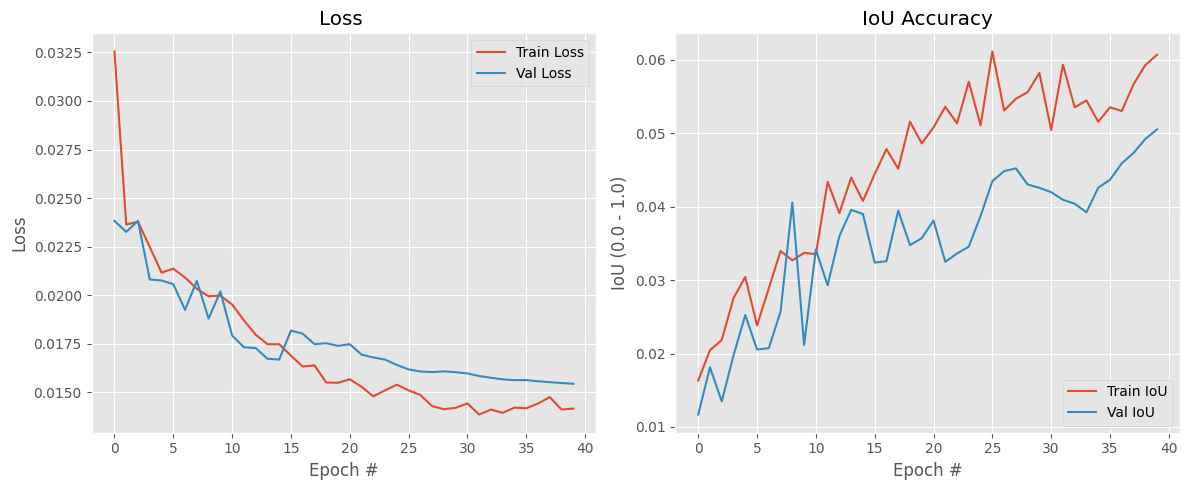

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("[INFO] Plotting NEW training history...")

if 'H1' not in globals() or 'H2' not in globals():
    print("[ERROR] New training history not found! Did you run Section 6 (Training)?")
else:
    # 1. Combine histories from Phase 1 (H1) and Phase 2 (H2)
    H_full = {}
    for key in H1.history.keys():
        H_full[key] = H1.history[key] + H2.history[key]

    # 2. Determine total epochs
    N = len(H_full["loss"])
    epochs_range = np.arange(0, N)

    # 3. Create the Plot
    plt.style.use("ggplot")
    plt.figure(figsize=(12, 5))

    # --- Plot 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, H_full["loss"], label="Train Loss")
    plt.plot(epochs_range, H_full["val_loss"], label="Val Loss")
    # Vertical line where Phase 2 started
    plt.title("Loss ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # --- Plot 2: IoU (Accuracy) ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, H_full["iou_metric"], label="Train IoU")
    plt.plot(epochs_range, H_full["val_iou_metric"], label="Val IoU")
    # Vertical line where Phase 2 started
    plt.title("IoU Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("IoU (0.0 - 1.0)")
    plt.legend(loc="lower right")

    # 4. Save and Show
    plt.tight_layout()
    # Save to the specific plot path defined earlier
    plt.savefig(PLOT_PATH if 'PLOT_PATH' in globals() else "mobilenet_plot.png")
    print("[INFO] Plot updated successfully.")
    plt.show()